In [1]:
import pandas as pd
import numpy as np
from scipy.special import expit
df = pd.read_csv('train.csv') # read in the csv file

df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [2]:
X, y = df.iloc[:, :20].values, df.iloc[:, 20].values

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [4]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [5]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, penalty=None, solver='sd'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.penalty = penalty
        self.solver = solver
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        if not self.solver or self.solver == 'sd':
            ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
            gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        if self.solver == 'sgd':
            idx = int(np.random.rand()*len(y)) # grab random instance
            ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
            gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
            
        
        gradient = gradient.reshape(self.w_.shape)
        if self.penalty == 'l2':
            gradient[1:] += -2 * self.w_[1:] * self.C
        if self.penalty == 'l1':
            for i in range(1, len(gradient)):
                if self.w_[i] > 0:
                    gradient[i] += -1 * self.C
                if self.w_[i] < 0:
                    gradient[i] += self.C
        if self.penalty == 'l12':
            gradient[1:] += (-2 * self.w_[1:] * self.C)
            for i in range(1, len(gradient)):
                if self.w_[i] > 0:
                    gradient[i] += -1 * self.C
                if self.w_[i] < 0:
                    gradient[i] += self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

            # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

Wall time: 0 ns


In [6]:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))


# bfgslr = BFGSBinaryLogisticRegression(_,10,C=0.001) # note that we need only a few iterations here

# bfgslr.fit(X,y)
# yhat = bfgslr.predict(X)
# print(bfgslr)
# print('Accuracy of: ',accuracy_score(y,yhat))

In [7]:
class LogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, penalty=None, solver='sd'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.penalty = penalty
        self.solver = solver
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            if self.solver == 'sd' or self.solver == 'sgd':
                blr = BinaryLogisticRegression(self.eta,self.iters, self.C, self.penalty, self.solver)
            if self.solver == 'bfgs':
                blr = BFGSBinaryLogisticRegression(self.eta,self.iters, self.C, self.penalty, self.solver)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):

        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    

In [8]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression(eta=0.1, iterations=1000, penalty='l2', C=0.001, solver='sd')
lr.fit(X_train_std, y_train)
print(lr)

yhat = lr.predict(X_test_std)
print('Accuracy of: %.3f' % accuracy_score(y_test, yhat))

MultiClass Logistic Regression Object with coefficients:
[[-3.11528829e+00 -9.09740174e-01 -3.94521666e-03  8.98279013e-02
   4.49714261e-02 -1.05342840e-01  3.18842184e-03 -7.92895938e-02
  -4.79294273e-02  5.00661573e-02  1.15179615e-01  4.84186555e-02
  -6.30755178e-01 -5.03483586e-01 -3.72181805e+00 -1.20715417e-02
   6.19865574e-02 -1.13017285e-01 -4.19341621e-02  8.00256004e-04
   8.25293569e-02]
 [-1.19436207e+00 -7.00035958e-02  4.76600211e-03 -1.64286280e-02
   2.54363837e-02  8.79651337e-02 -2.21736492e-02  5.92884045e-02
   8.67960300e-02  9.34378193e-03 -1.29659227e-01 -5.19635370e-02
   8.65233253e-02 -5.99338422e-02 -5.60713874e-01  2.59340391e-02
  -1.04554129e-01  1.34196498e-01  9.51546317e-03  6.64382683e-02
  -6.92649243e-02]
 [-1.20457720e+00  7.19559630e-03 -5.12560304e-02  6.76389299e-03
  -5.24930933e-02  4.02707297e-02 -1.26708866e-01 -1.26227876e-01
  -5.67946343e-02  1.57481931e-01  8.73586156e-02 -8.10849959e-03
   1.73174927e-02 -5.70483975e-03  5.97108265e-

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in multiply
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in add
No handles with labels found to put in legend.


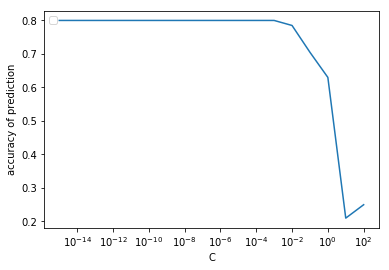

In [26]:
import matplotlib.pyplot as plt
accuracy, params = [], []
for c in np.arange(-15, 3):
    lr = LogisticRegression(eta=0.1, iterations=1000, penalty='l2', C=10.**c, solver='sd')
    lr.fit(X_train_std, y_train)
    yhat = lr.predict(X_test_std)
    accuracy.append(accuracy_score(y_test, yhat))
    params.append(10.**c)
accuracy = np.array(accuracy)
plt.plot(params, accuracy)
plt.ylabel('accuracy of prediction')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

No handles with labels found to put in legend.


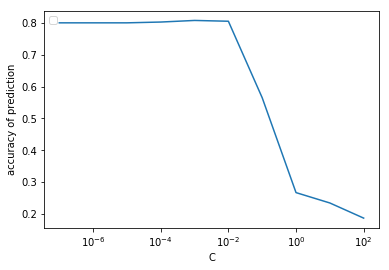

In [14]:
import matplotlib.pyplot as plt
accuracy, params = [], []
for c in np.arange(-7, 3):
    lr = LogisticRegression(eta=0.1, iterations=1000, penalty='l1', C=10.**c, solver='sd')
    lr.fit(X_train_std, y_train)
    yhat = lr.predict(X_test_std)
    accuracy.append(accuracy_score(y_test, yhat))
    params.append(10.**c)
accuracy = np.array(accuracy)
plt.plot(params, accuracy)
plt.ylabel('accuracy of prediction')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in multiply
No handles with labels found to put in legend.


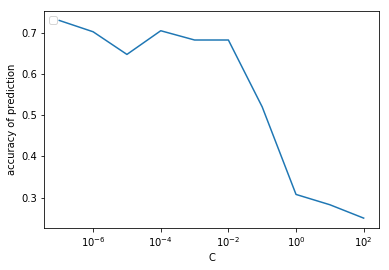

In [15]:
import matplotlib.pyplot as plt
accuracy, params = [], []
for c in np.arange(-7, 3):
    lr = LogisticRegression(eta=0.1, iterations=1000, penalty='l2', C=10.**c, solver='sgd')
    lr.fit(X_train_std, y_train)
    yhat = lr.predict(X_test_std)
    accuracy.append(accuracy_score(y_test, yhat))
    params.append(10.**c)
accuracy = np.array(accuracy)
plt.plot(params, accuracy)
plt.ylabel('accuracy of prediction')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

No handles with labels found to put in legend.


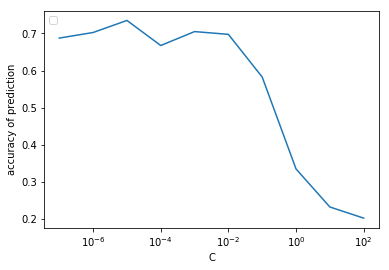

In [16]:
import matplotlib.pyplot as plt
accuracy, params = [], []
for c in np.arange(-7, 3):
    lr = LogisticRegression(eta=0.1, iterations=1000, penalty='l1', C=10.**c, solver='sgd')
    lr.fit(X_train_std, y_train)
    yhat = lr.predict(X_test_std)
    accuracy.append(accuracy_score(y_test, yhat))
    params.append(10.**c)
accuracy = np.array(accuracy)
plt.plot(params, accuracy)
plt.ylabel('accuracy of prediction')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

No handles with labels found to put in legend.


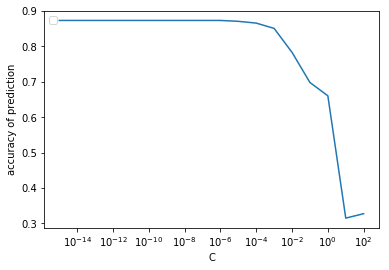

In [24]:
import matplotlib.pyplot as plt
accuracy, params = [], []
for c in np.arange(-15, 3):
    lr = LogisticRegression(eta=0.1, iterations=11, penalty='l2', C=10.**c, solver='bfgs')
    lr.fit(X_train_std, y_train)
    yhat = lr.predict(X_test_std)
    accuracy.append(accuracy_score(y_test, yhat))
    params.append(10.**c)
accuracy = np.array(accuracy)
plt.plot(params, accuracy)
plt.ylabel('accuracy of prediction')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression(max_iter=1000, penalty='l1', C=1, solver='saga') # all params default

lr_sk.fit(X_train_std, y_train)
yhat = lr_sk.predict(X_test_std)
print('Accuracy of: ',accuracy_score(y_test,yhat))

F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy of:  0.8875


In [28]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
from numpy.linalg import pinv
class MSEBinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MSE Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
#         ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
#         gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
#         gradient = gradient.reshape(self.w_.shape)
#         gradient = gradient * 2
        
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = (np.mean(X * ydiff[:,np.newaxis], axis=0)) * 2 # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

            # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient * self.eta # multiply by learning rate 

Wall time: 0 ns


In [29]:
X = df.iloc[:, :20].values
y = (df.iloc[:, 20]>1).astype(np.int).values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [33]:
blr = MSEBinaryLogisticRegression(eta=0.1, iterations=1, C=0.001)

blr.fit(X_train_std, y_train)
print(blr)

yhat = blr.predict(X_test_std)
print('Accuracy of: %.3f' % accuracy_score(y_test, yhat))

MSE Binary Logistic Regression Object with coefficients:
[[ 1.31320015e-09]
 [ 3.81948197e-05]
 [-3.91647146e-06]
 [ 2.70986739e-06]
 [-6.25917565e-06]
 [ 2.86715778e-06]
 [-2.04250130e-06]
 [-1.87150155e-06]
 [-6.78227321e-06]
 [-2.55629705e-06]
 [ 8.33523031e-06]
 [-4.28132857e-06]
 [ 1.86109223e-05]
 [ 1.93291486e-05]
 [ 2.06005436e-04]
 [-3.25584984e-06]
 [ 1.87562068e-06]
 [-3.05015748e-06]
 [ 3.07943990e-06]
 [-3.46271779e-06]
 [-8.90651237e-07]]
Accuracy of: 0.950
